In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.tinto import TINTO
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST: ACC = 0.733152

In [4]:
folder="data/FOREX_cadjpy-day-High"
x_col=["Bid_Open", "Bid_High", "Bid_Low", "Bid_Close", "Bid_Volume", "Ask_Open", "Ask_High", "Ask_Low", "Ask_Close","Ask_Volume"]
target_col=["class"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)

    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #print(X_train_full)
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    max_c = max(max_row, max_col)
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(19 + 1) for c in range(19 + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
dtype = torch.get_default_dtype()
min_expected = 0.
max_expected = 1.

In [11]:
def plot_training_ACC(y_true, y_pred, train_loss, val_loss):
    clipped = torch.clamp(torch.round(y_pred), min=min_expected, max=max_expected)
    avg_acc = torch.mean((clipped == y_true).type(dtype))
    print(avg_acc)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('Accuracy')
    plt.xlabel('step')
    plt.yscale('log')

In [12]:
def plot_confusion_matrix(y_true_tensor, y_pred_tensor, title="Confusion Matrix"):
    # Move tensors to CPU and detach if necessary
    clipped = torch.clamp(torch.round(y_pred_tensor), min=min_expected, max=max_expected)
    
    
    y_true = y_true_tensor.detach().cpu().numpy().flatten()
    y_pred = clipped.detach().cpu().numpy().flatten()

    # Round predictions if they are float (e.g., from sigmoid or regression)
    if y_pred.dtype.kind in {'f'}:
        y_pred = y_pred.round()

    # Get sorted list of all unique labels
    all_labels = sorted(set(y_true) | set(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [13]:
def train_acc_kan():
    rounded = torch.round(torch.round(model(dataset['train_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_kan():
    rounded = torch.round(torch.round(model(dataset['val_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

In [14]:
def plot_sorted_feature_importance(columns, importances):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    sorted_columns, sorted_importances = zip(*sorted_pairs)

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_columns, sorted_importances, color='royalblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances (Sorted)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [15]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1., start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
               metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                val_metric = val_loss
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    val_metric = results[metric][-1]
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = epoch
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [16]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        if not 'Ex' in col:
            abbrev = col.split("-")[0][:5]
            if i < len(coordinate[0]):
                r, c = coordinate[0][i], coordinate[1][i]
                ry = r * zoom + zoom // 2
                cx = c * zoom + zoom // 2
                if ry < h and cx < w:
                    axs[1].text(cx, ry, abbrev,
                                color='white', fontsize=9, ha='center', va='center',
                                bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                    axs[0].text(cx, ry, abbrev,
                                color='white', fontsize=9, ha='center', va='center',
                                bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [17]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    features, scores = zip(*sorted_scores)

    plt.figure(figsize=(12, 6))
    plt.barh(features, scores, color='royalblue')
    plt.xlabel("Grad-CAM Relevance")
    plt.title("Feature Relevance from Single Instance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [18]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Combines all steps: compute average relevance and plot.
    """
    avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
    plot_feature_relevance_bar(avg_scores)
    return avg_scores

### CNN Functions

In [19]:
def train_acc_cnn():
    rounded = torch.round(torch.round(model(0, dataset['train_img'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_cnn():
    rounded = torch.round(torch.round(model(0, dataset['val_img'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

In [20]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS", metrics=None, display_metrics=None):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}

    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if display_metrics == None:
            pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                val_metric = results[metric][-1]
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = step
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [21]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [22, 13, 8]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

### Hybrid Functions

In [22]:
def train_acc_hybrid():
    rounded = torch.round(torch.round(model(dataset['train_input'], dataset['train_img'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_hybrid():
    rounded = torch.round(torch.round(model(dataset['val_input'], dataset['val_img'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

In [23]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=6, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [24]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())


        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                val_metric = results[metric][-1]
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = step
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [25]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [26]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid,cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 13, 13]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [27]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # 32 x 2 x 2
            
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.LayerNorm([64, 4, 4]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

# Load Dataset & Images

In [28]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [29]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(num_columns))
print(image_size)

4


In [30]:
dataset_name = 'FOREX_cadjpy-day-High'
#Select the model and the parameters
problem_type = "supervised"
pixel=20
image_model = TINTO(problem=problem_type, blur=False, pixels=pixel, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Classification/{dataset_name}/images_{dataset_name}_{name}"

In [31]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 20, 20)
Attributes:  10


In [34]:
coordinates = (image_model.pos_pixel_caract[:, 0].astype(int), image_model.pos_pixel_caract[:, 1].astype(int))

In [35]:
coordinates

(array([ 7,  7,  7,  7, 18,  8,  7,  7,  7, 18]),
 array([10,  9, 10, 10,  9, 10,  9, 10, 10, 10]))

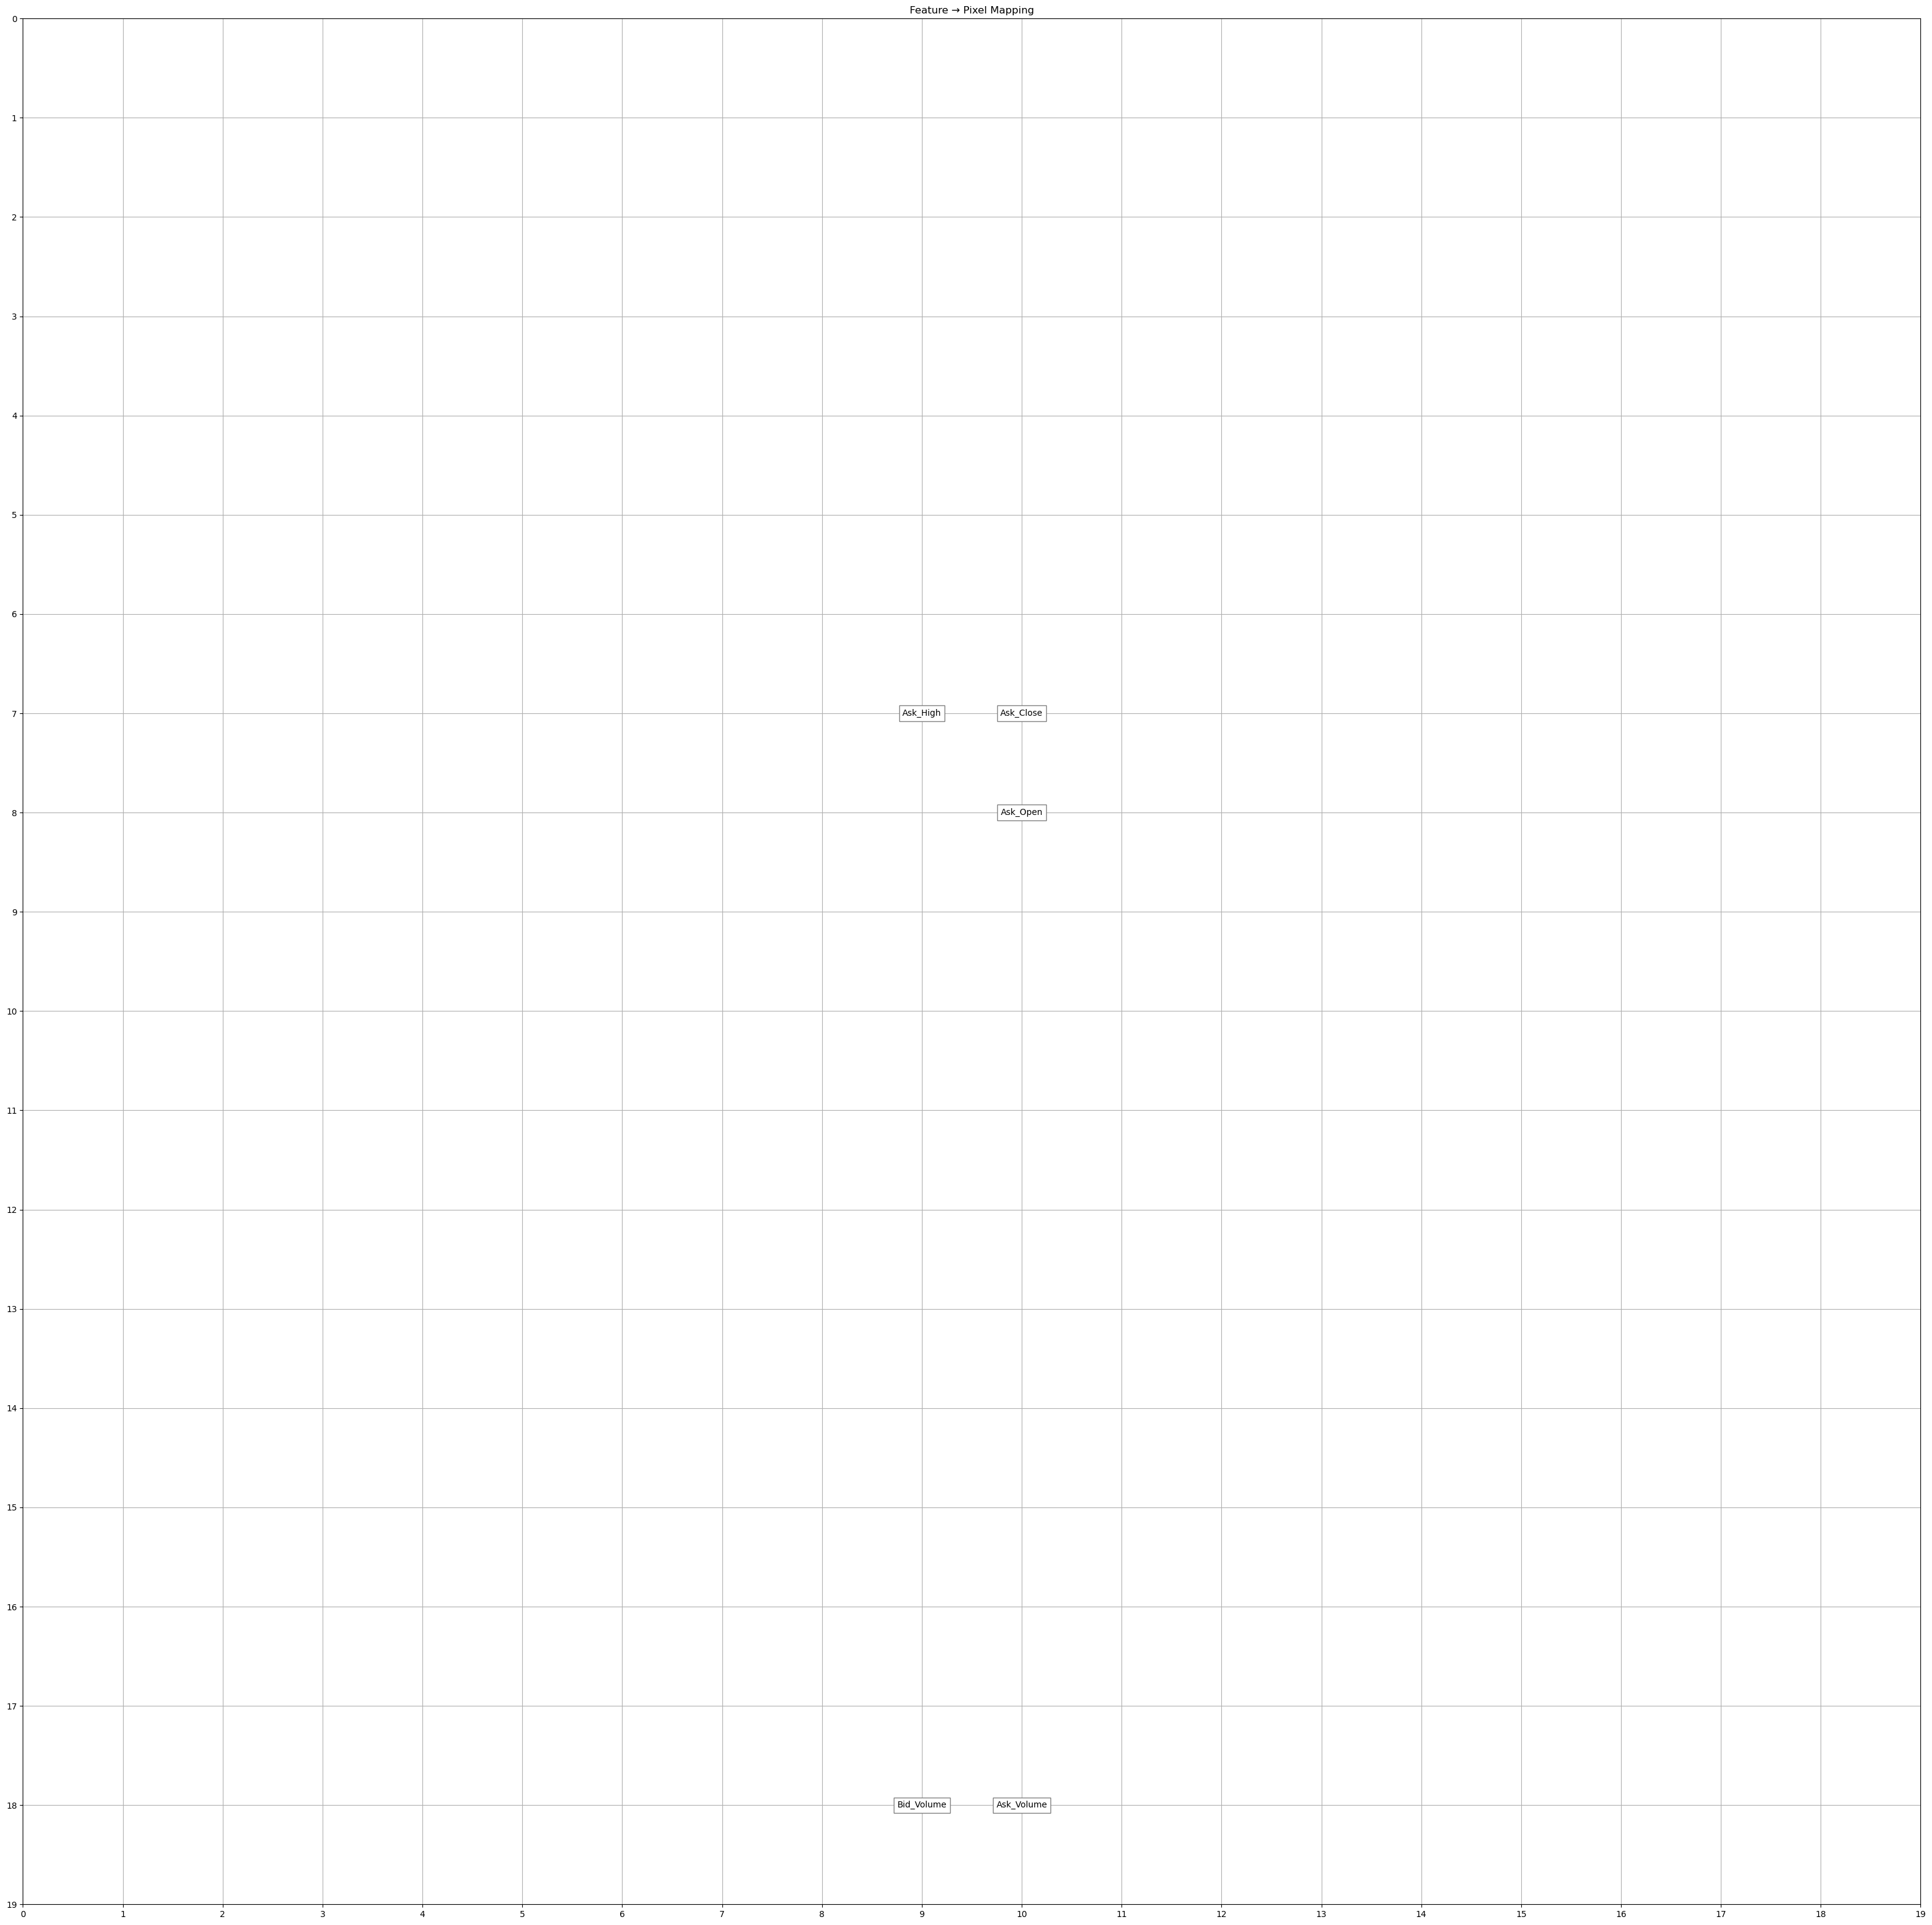

In [32]:
if hasattr(image_model, 'coordinate'):
    coordinates = image_model.coordinate
else:
    coordinates = (np.array([ 7,  7,  7,  7, 18,  8,  7,  7,  7, 18]),
                 np.array([10,  9, 10, 10,  9, 10,  9, 10, 10, 10]))

plot_feature_mapping(x_col, coordinates, scale=[20, 20])

In [33]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [34]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([1173, 10])
Train target shape: torch.Size([1173, 1])
Test data shape: torch.Size([367, 10])
Test target shape: torch.Size([367, 1])
Validation data shape: torch.Size([294, 10])
Validation target shape: torch.Size([294, 1])


In [35]:
completed_coordinate, completed_x_col = complete_coordinate_and_xcol(coordinates, x_col)

# KAN training ✅ Top 2 Configurations

### 1. width=[10, 3, 1], grid=3, lamb=1e-06 | best_epoch=3 | acc_test=0.74932

checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.42e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.49it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 3 epoch
tensor(0.7084, device='cuda:0')


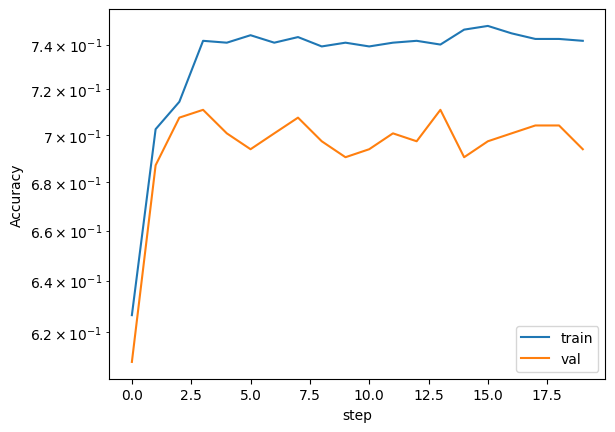

In [88]:
model = KAN(width=[attributes, 3, 1], grid=3, k=3, seed=381, device=device)
best_model_state, results, _ = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=1e-06,
                                          metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
plot_training_ACC(model, best_model_state, dataset['test_label'][:,0], model(dataset['test_input'])[:,0],
                  results['train_acc_kan'], results['val_acc_kan'])

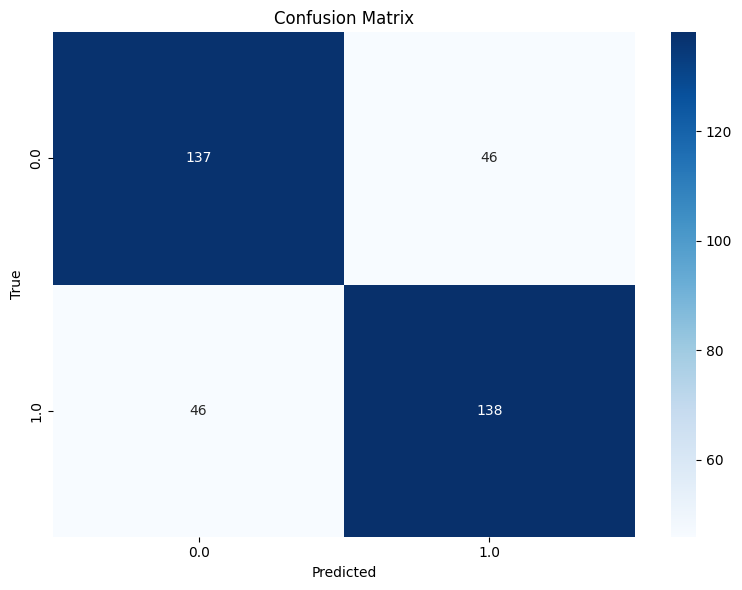

In [89]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'])[:,0], title="Confusion Matrix")

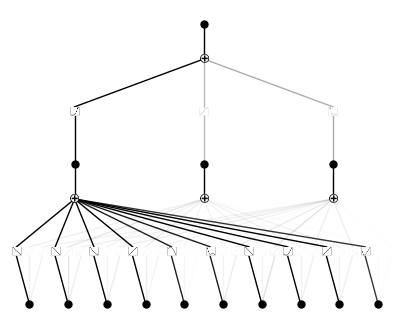

In [90]:
model.plot()

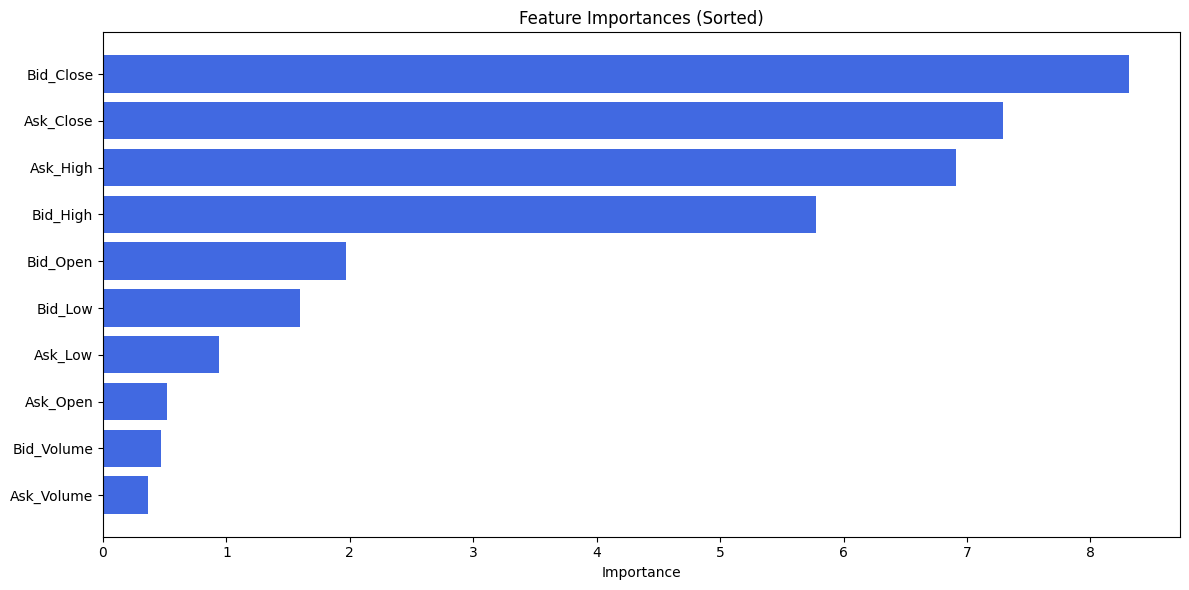

In [91]:
plot_sorted_feature_importance(x_col, model.feature_score)

### 2. width=[10, 3, 1], grid=4, lamb=0.0001 | best_epoch=3 | acc_test=0.74659

checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.41it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 2 epoch
tensor(0.7003, device='cuda:0')


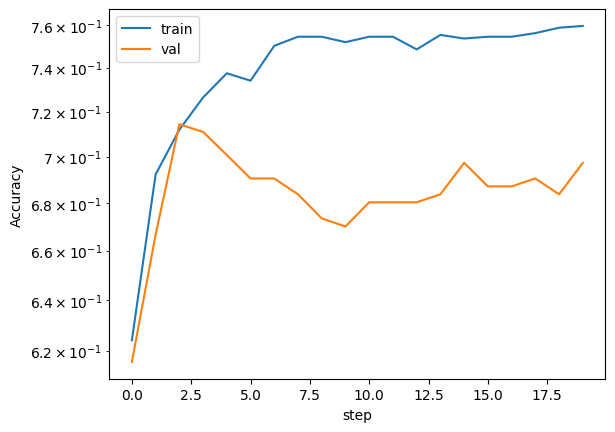

In [40]:
model = KAN(width=[attributes, 3, 1], grid=4, k=3, seed=381, device=device)
best_model_state, results, _ = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=0.0001,
                                          metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
plot_training_ACC(model, best_model_state, dataset['test_label'][:,0], model(dataset['test_input'])[:,0],
                  results['train_acc_kan'], results['val_acc_kan'])

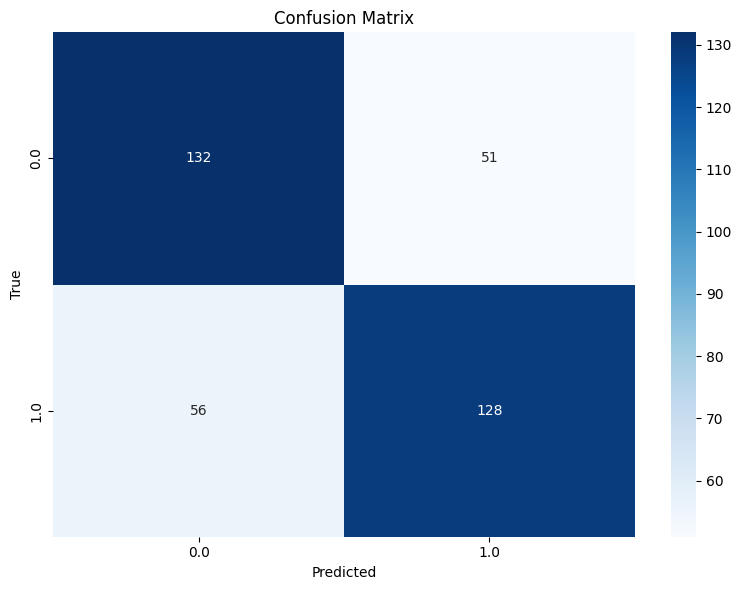

In [41]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'])[:,0], title="Confusion Matrix")

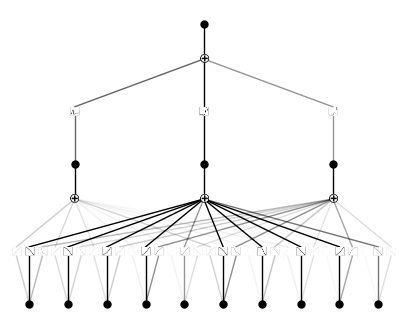

In [42]:
model.plot()

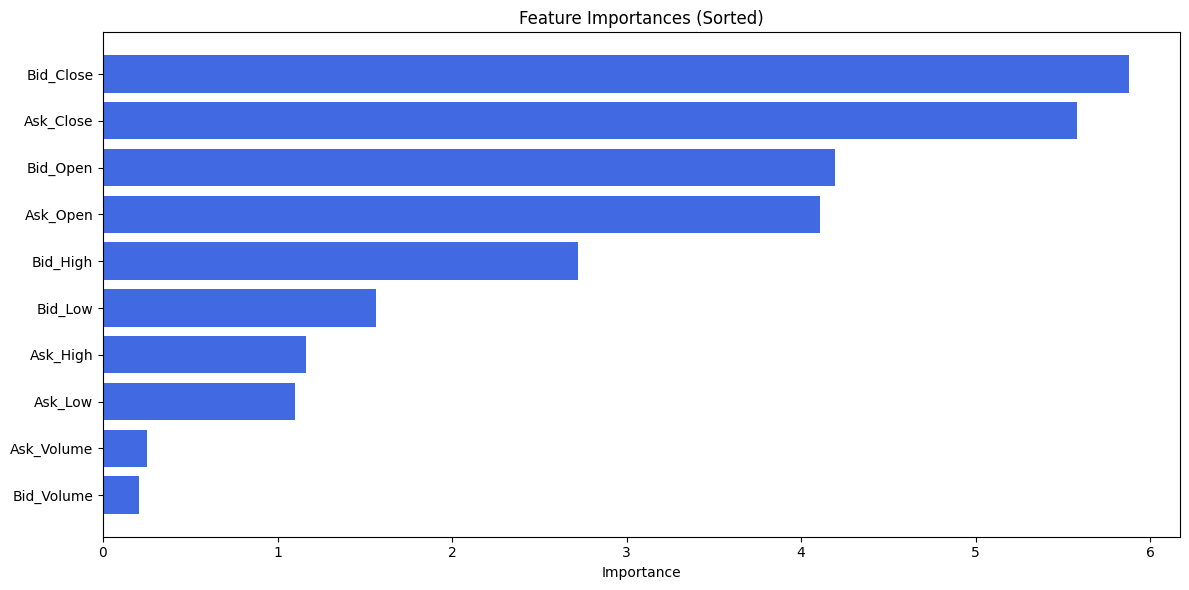

In [43]:
plot_sorted_feature_importance(x_col, model.feature_score)

# CNN training ✅ Top 2 Configurations

### 1. cnn_blocks=1, dense_layers=1 | best_epoch=32 | acc=0.71662

In [46]:
#avg_acc0.73569_cnn3_d3_e15
base_path= "FOREX_cadjpy-day-High_TINTO_info/CNN_avg_acc0.70845_cnn3_d3_e39"
model_path = f"{base_path}/model.pt"  # e.g. './best_models/loss0.20876_h10_g5_l1e-03_e32/model.pt'
model = build_custom_cnn_model(cnn_blocks=3, dense_layers=3, imgs_shape=imgs_shape)
model.load_state_dict(torch.load(model_path))

# 3. Set model to eval mode (if using for inference or Grad-CAM)
model.eval()

/tmp/ipykernel_2675/2426399366.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


CustomCNNModel(
  (cnn_branch): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (9): LayerNorm((64, 8, 8), eps=1e-05, elementwise_affine=True)
    (10): Sigmoid()
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_fe

tensor(0.7112, device='cuda:0')


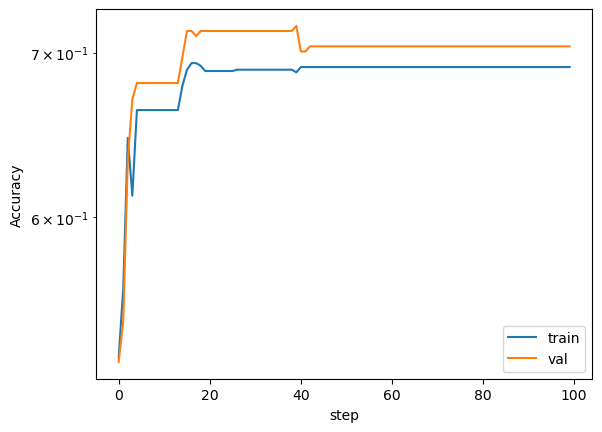

In [47]:
train = np.load(f"{base_path}/train_loss.npy")
val = np.load(f"{base_path}/val_loss.npy")

plot_training_ACC(dataset['test_label'][:,0], model(0, dataset['test_img'])[:,0],
                  train, val)

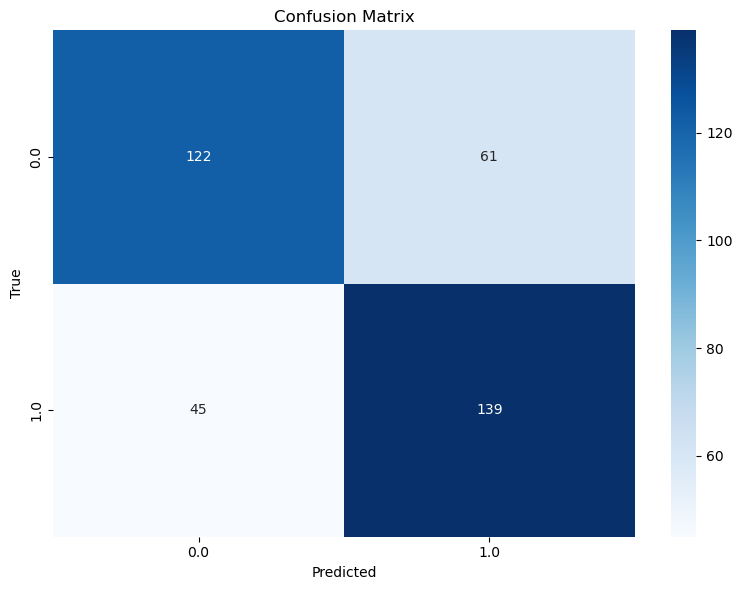

In [48]:
plot_confusion_matrix(dataset['test_label'][:,0], model(0, dataset['test_img'])[:,0], title="Confusion Matrix")

/tmp/ipykernel_2675/1915381523.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state=torch.load(model_path),


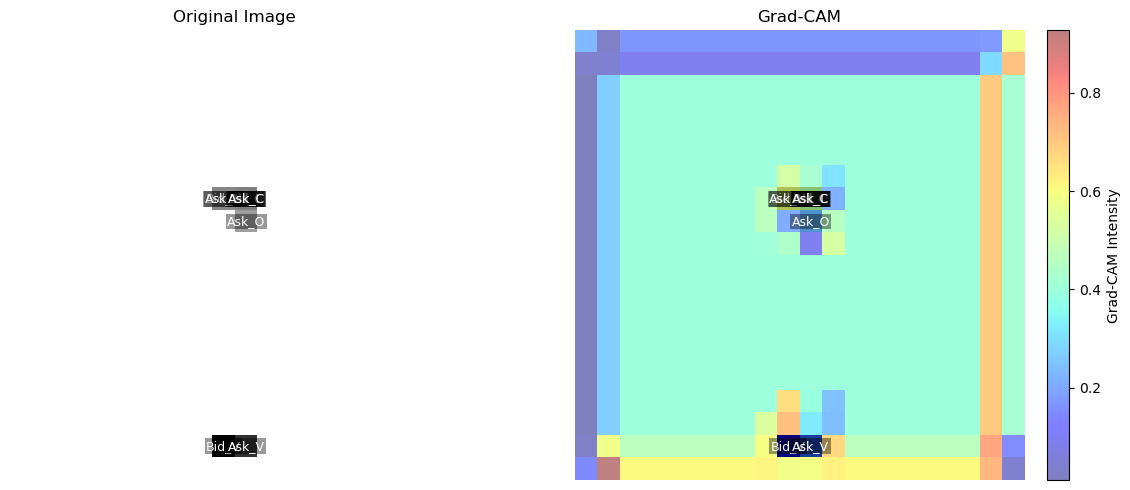

In [52]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=torch.load(model_path),
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

/tmp/ipykernel_2675/3767583146.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state=torch.load(model_path),
Computing Grad-CAM: 100%|██████████| 367/367 [00:28<00

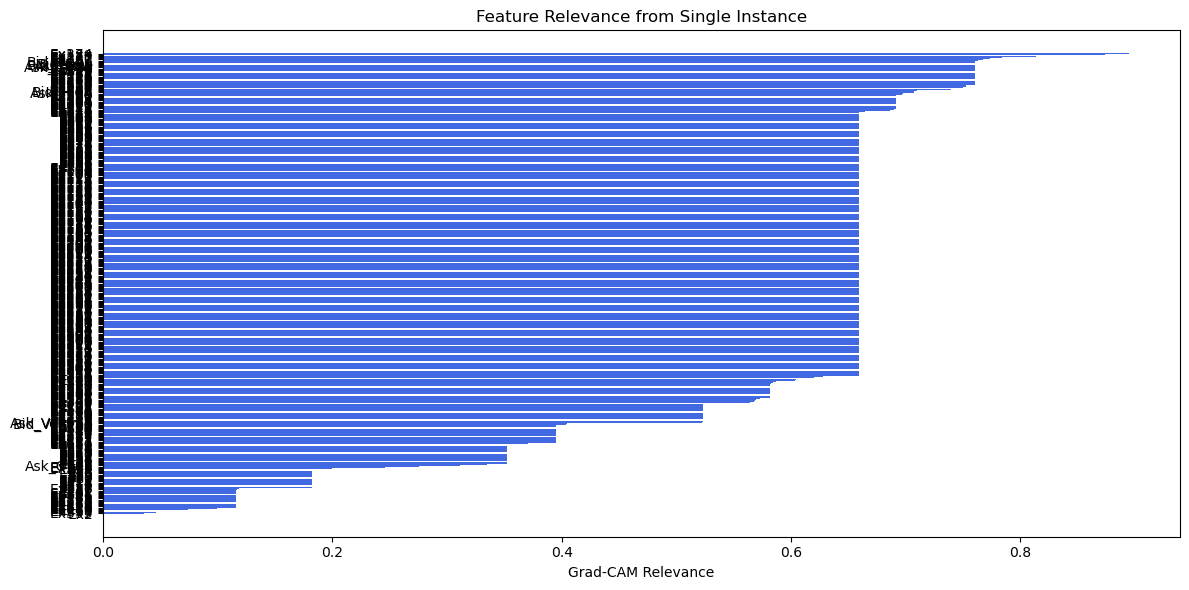

{'Bid_Open': 0.7604860359706411,
 'Bid_High': 0.7067568885208151,
 'Bid_Low': 0.7604860359706411,
 'Bid_Close': 0.7604860359706411,
 'Bid_Volume': 0.4047698919592826,
 'Ask_Open': 0.31119978959781275,
 'Ask_High': 0.7067568885208151,
 'Ask_Low': 0.7604860359706411,
 'Ask_Close': 0.7604860359706411,
 'Ask_Volume': 0.5222311410900683,
 'Ex1': 0.3348891487377732,
 'Ex2': 0.03612591605633497,
 'Ex3': 0.1818658157939482,
 'Ex4': 0.1818658157939482,
 'Ex5': 0.1818658157939482,
 'Ex6': 0.1818658157939482,
 'Ex7': 0.1818658157939482,
 'Ex8': 0.1818658157939482,
 'Ex9': 0.1818658157939482,
 'Ex10': 0.1818658157939482,
 'Ex11': 0.1818658157939482,
 'Ex12': 0.1818658157939482,
 'Ex13': 0.1818658157939482,
 'Ex14': 0.1818658157939482,
 'Ex15': 0.1818658157939482,
 'Ex16': 0.1818658157939482,
 'Ex17': 0.1818658157939482,
 'Ex18': 0.1818658157939482,
 'Ex19': 0.07390753183341318,
 'Ex20': 0.4037910953204703,
 'Ex21': 0.1999858424917773,
 'Ex22': 0.11647069511036783,
 'Ex23': 0.3519100928298459,
 'Ex

In [53]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=torch.load(model_path),
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)
plot_feature_relevance_bar(avg_scores)
avg_scores

### 3. cnn_blocks=3, dense_layers=3 | best_epoch=35 | acc=0.69482

 train_acc_cnn: 7.52e-01 | val_acc_cnn: 6.94e-01 |: 100%|█████████| 100/100 [00:15<00:00,  6.65it/s]


✅ Best validation Accuracy: 7.4150e-01 at 12 epoch
tensor(0.6785, device='cuda:0')


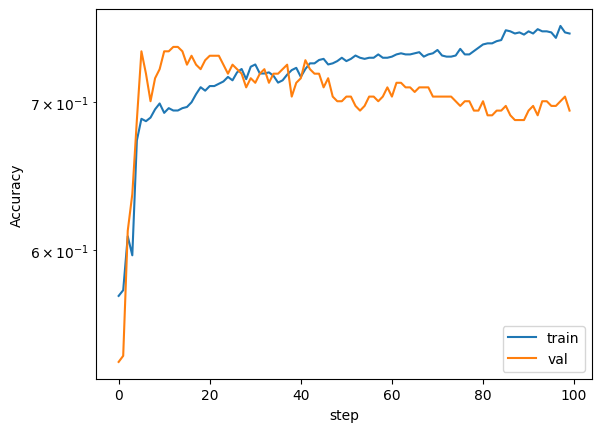

In [49]:
model = build_custom_cnn_model(cnn_blocks=3, dense_layers=3, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model, dataset, steps=100, opt='LBFGS', batch=-1, 
                                            metrics=(train_acc_cnn, val_acc_cnn), display_metrics=['train_acc_cnn', 'val_acc_cnn'])

plot_training_ACC(model, model_state, dataset['test_label'][:,0], model(0, dataset['test_img'])[:,0],
                  results['train_acc_cnn'], results['val_acc_cnn'])

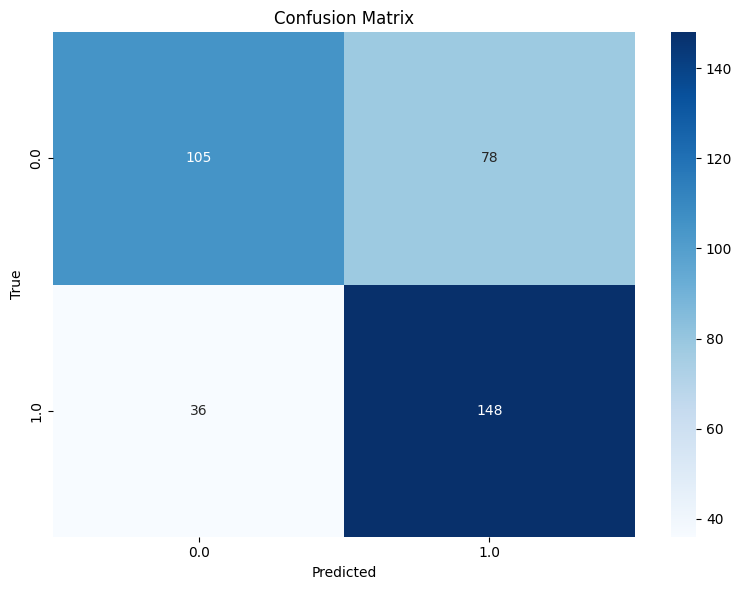

In [50]:
plot_confusion_matrix(dataset['test_label'][:,0], model(0, dataset['test_img'])[:,0], title="Confusion Matrix")

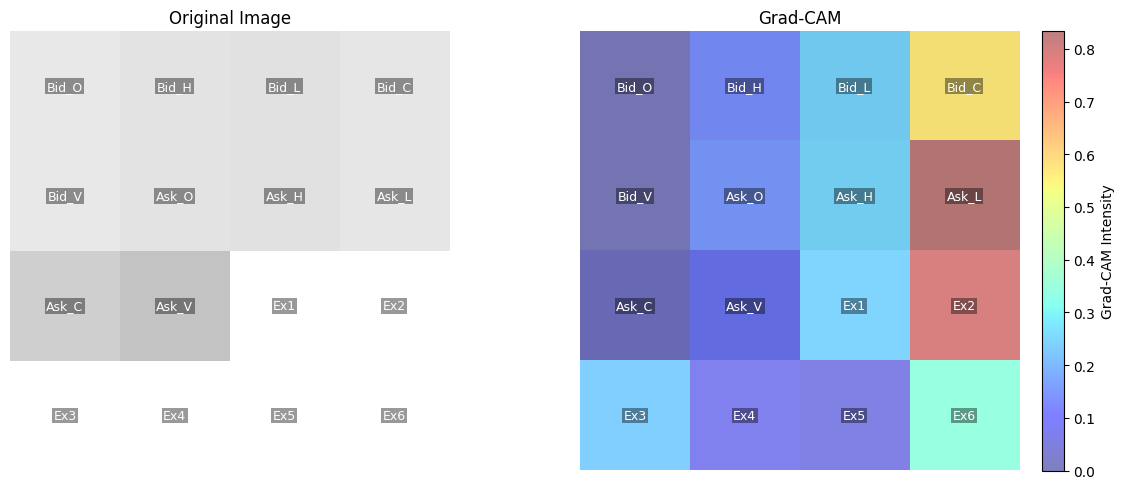

In [51]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

In [52]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)

Computing Grad-CAM: 100%|██████████| 367/367 [00:22<00:00, 16.29it/s]


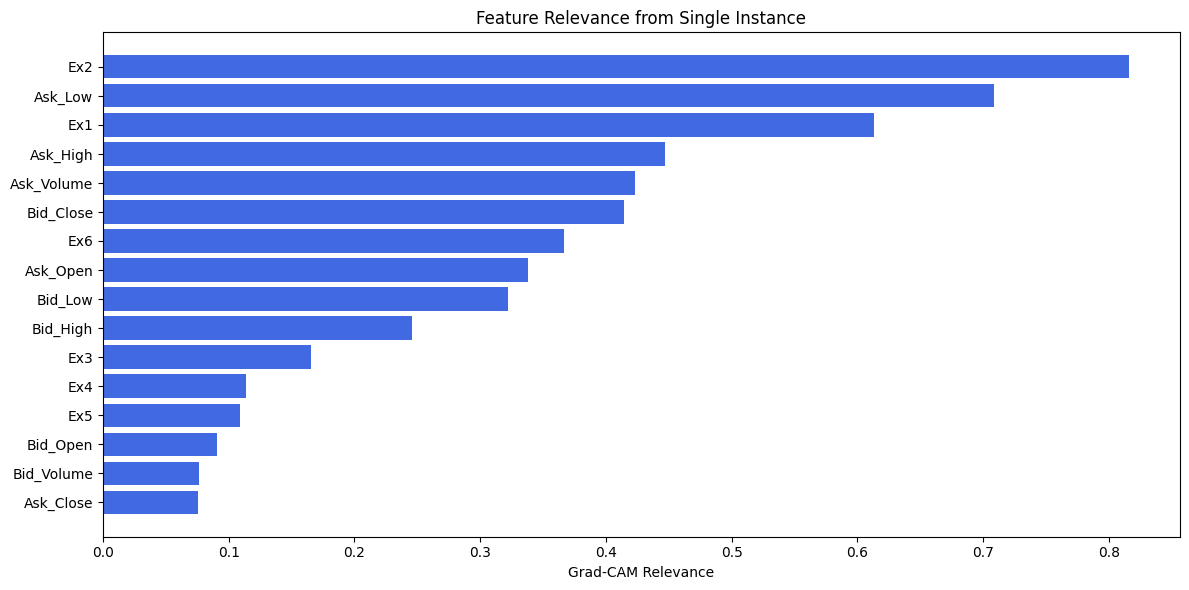

In [53]:
plot_feature_relevance_bar(avg_scores)

# Hibrid Model3 training ✅ Top 2 Configurations

### 1. width=[10, 1, 1], grid=3, lamb=0.0001| best_epoch=6 | avg_acc=0.73025

In [41]:
base_path= "FOREX_cadjpy-day-High_TINTO_info/Hybrid_avg_acc0.71935_h5_g6_l0.0001_e31"
model_path = f"{base_path}/model.pt"  # e.g. './best_models/loss0.20876_h10_g5_l1e-03_e32/model.pt'
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=5, kan_grid=6)  # Attempt to create Model3
model.load_state_dict(torch.load(model_path))

# 3. Set model to eval mode (if using for inference or Grad-CAM)
model.eval()

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


/tmp/ipykernel_2704/1722377874.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model3(
  (cnn_branch): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): LayerNorm((32, 13, 13), eps=1e-05, elementwise_affine=True)
    (6): Sigmoid()
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (m_kan): MultKAN(
    (act_fun): ModuleList(
      (0): KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0): Symbolic_KANLayer()
    )
  )
  (final_kan): MultKAN(
    (act_fun): ModuleList(
      (0): KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0): Symbolic_KANLayer()
    )
  )
)

tensor(0.7030, device='cuda:0')


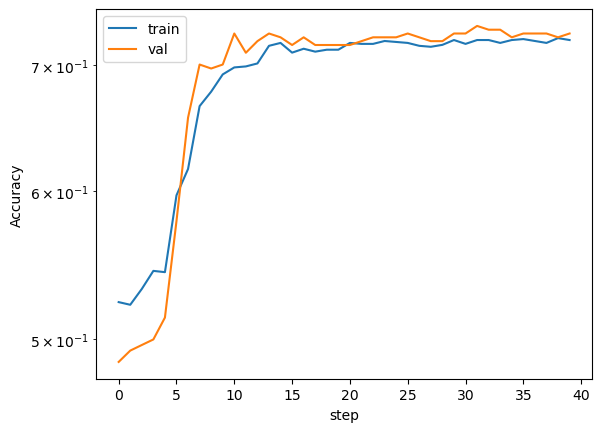

In [42]:
train = np.load(f"{base_path}/train_loss.npy")
val = np.load(f"{base_path}/val_loss.npy")
plot_training_ACC(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                  train, val)

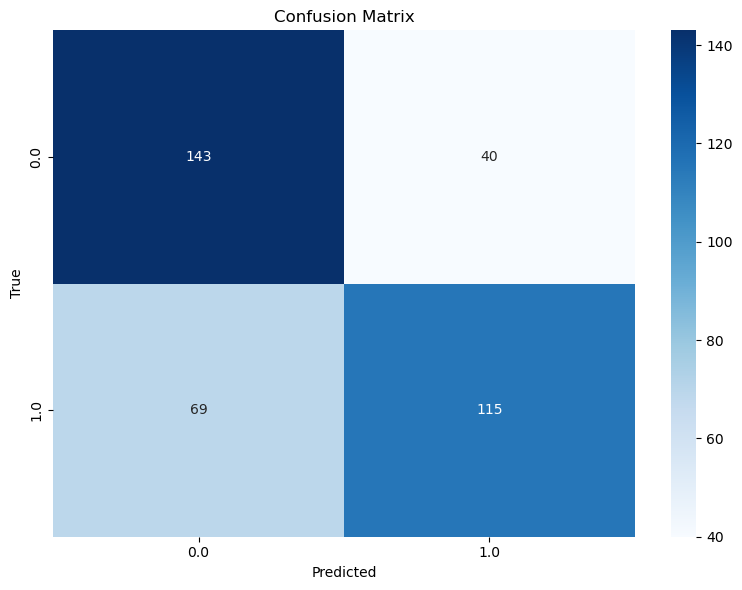

In [63]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

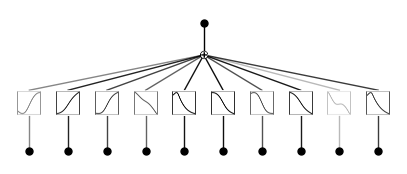

In [56]:
model.m_kan.plot()

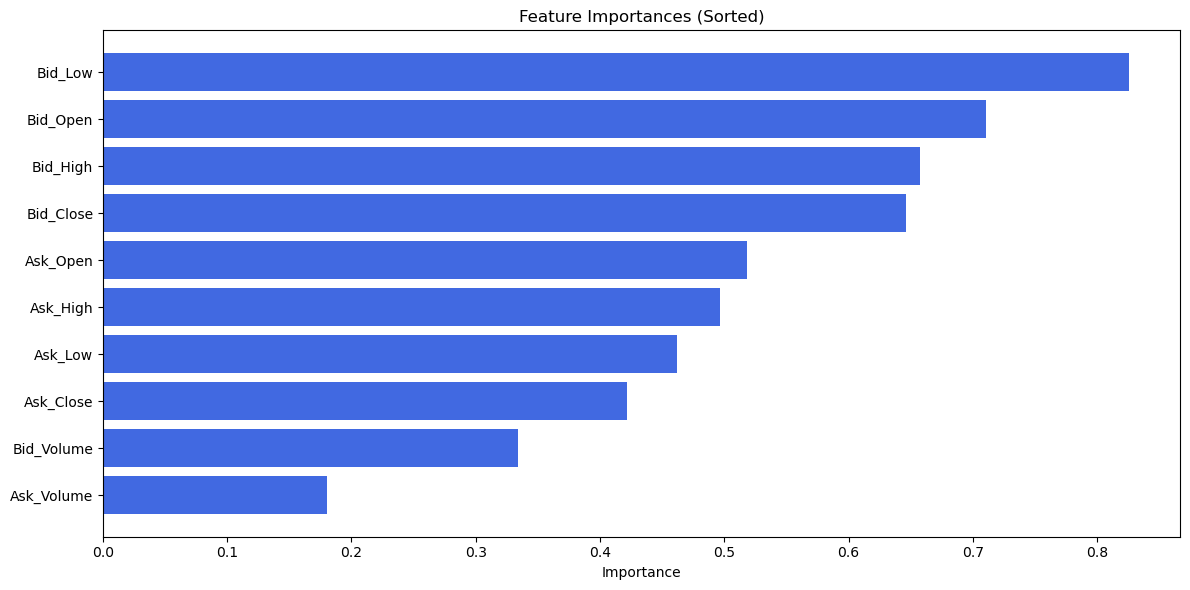

tensor([0.7107, 0.6572, 0.8255, 0.6462, 0.3343, 0.5182, 0.4965, 0.4622, 0.4220,
        0.1802], device='cuda:0', grad_fn=<MeanBackward1>)

In [65]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
model.m_kan.feature_score

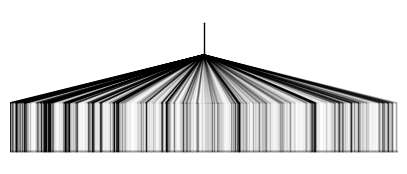

In [58]:
model.final_kan.plot()

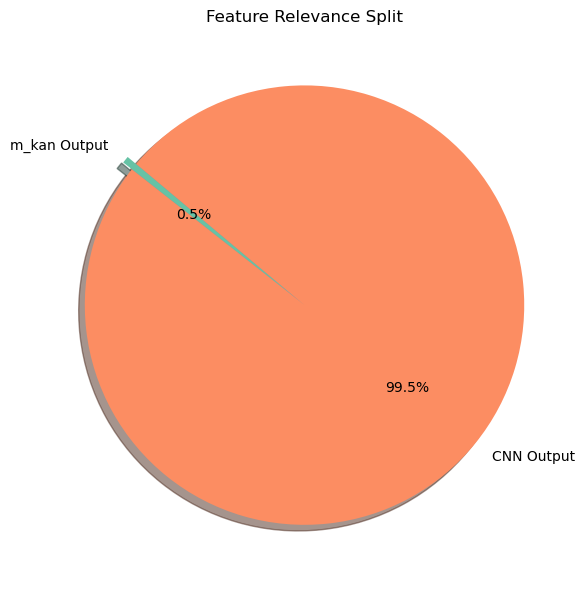

In [43]:
feature_score = model.final_kan.feature_score
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=5)

/tmp/ipykernel_2675/1915381523.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state=torch.load(model_path),
/home/jovyan/pykan/kan/MultKAN.py:816: UserWarning: st

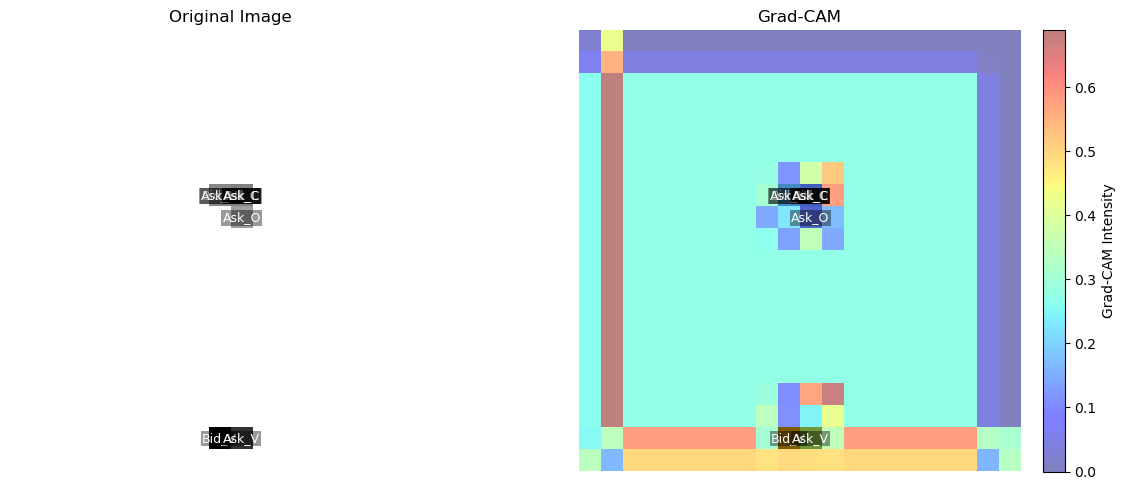

In [67]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=torch.load(model_path),
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

/tmp/ipykernel_2675/3767583146.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state=torch.load(model_path),
Computing Grad-CAM: 100%|██████████| 367/367 [24:32<00

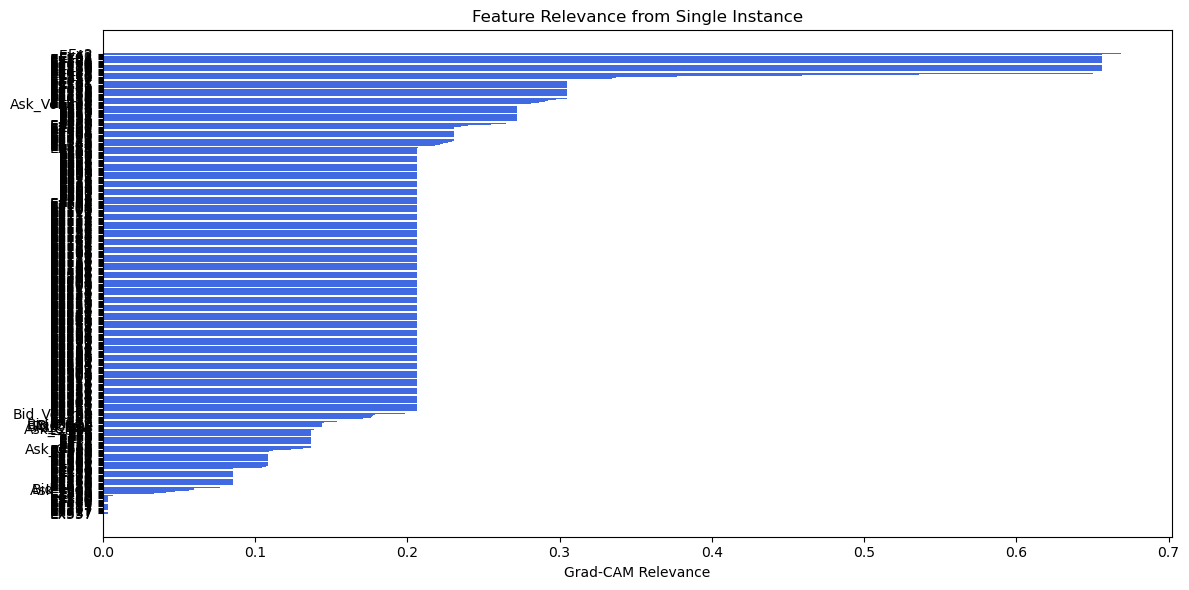

{'Bid_Open': 0.14364130821104235,
 'Bid_High': 0.05959938787975747,
 'Bid_Low': 0.14364130821104235,
 'Bid_Close': 0.14364130821104235,
 'Bid_Volume': 0.1981253189374807,
 'Ask_Open': 0.13145738176432722,
 'Ask_High': 0.05959938787975747,
 'Ask_Low': 0.14364130821104235,
 'Ask_Close': 0.14364130821104235,
 'Ask_Volume': 0.28102290435582816,
 'Ex1': 0.45918508731011753,
 'Ex2': 0.6685812565314391,
 'Ex3': 0.13695023780425677,
 'Ex4': 0.13695023780425677,
 'Ex5': 0.13695023780425677,
 'Ex6': 0.13695023780425677,
 'Ex7': 0.13695023780425677,
 'Ex8': 0.13695023780425677,
 'Ex9': 0.13695023780425677,
 'Ex10': 0.13695023780425677,
 'Ex11': 0.13695023780425677,
 'Ex12': 0.13695023780425677,
 'Ex13': 0.13695023780425677,
 'Ex14': 0.13695023780425677,
 'Ex15': 0.13695023780425677,
 'Ex16': 0.13695023780425677,
 'Ex17': 0.13695023780425677,
 'Ex18': 0.13695023780425677,
 'Ex19': 0.0335556817861001,
 'Ex20': 0.006600772637708151,
 'Ex21': 0.2351022834435349,
 'Ex22': 0.6505885344069725,
 'Ex23': 

In [68]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=torch.load(model_path),
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)
plot_feature_relevance_bar(avg_scores)
avg_scores

### 2. width=[10, 4, 1], grid=3, lamb=0.0001| best_epoch=7 | avg_acc=0.73025

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [00:30<00:00,  1.94it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 10 epoch
tensor(0.6812, device='cuda:0')


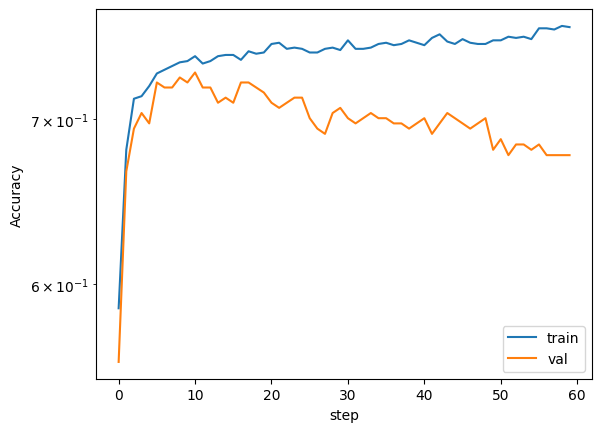

In [62]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=4, kan_grid=3)  # Attempt to create Model3
model_state, results, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=60, lamb=0.0001,
                                                   metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])

plot_training_ACC(model, model_state, dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                  results['train_acc_hybrid'], results['val_acc_hybrid'])

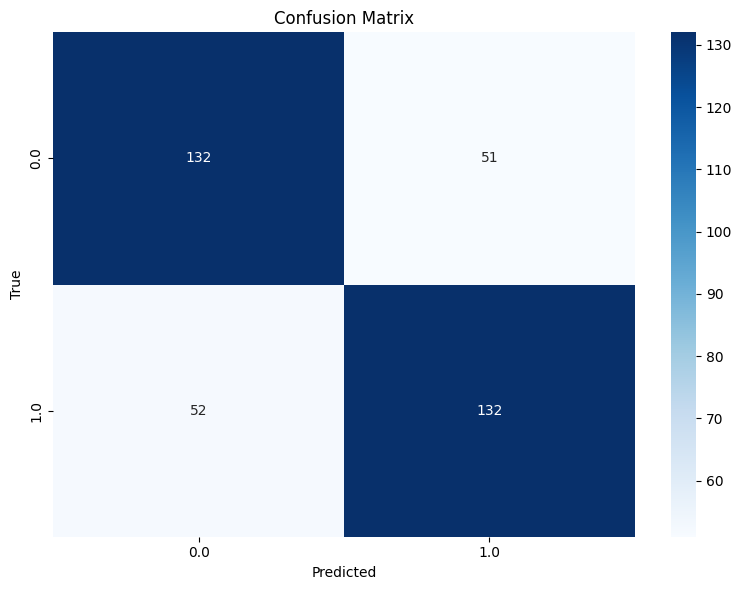

In [63]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

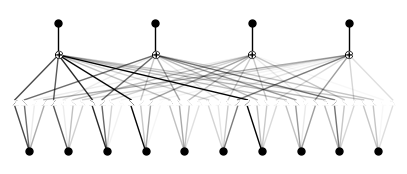

In [64]:
model.m_kan.plot()

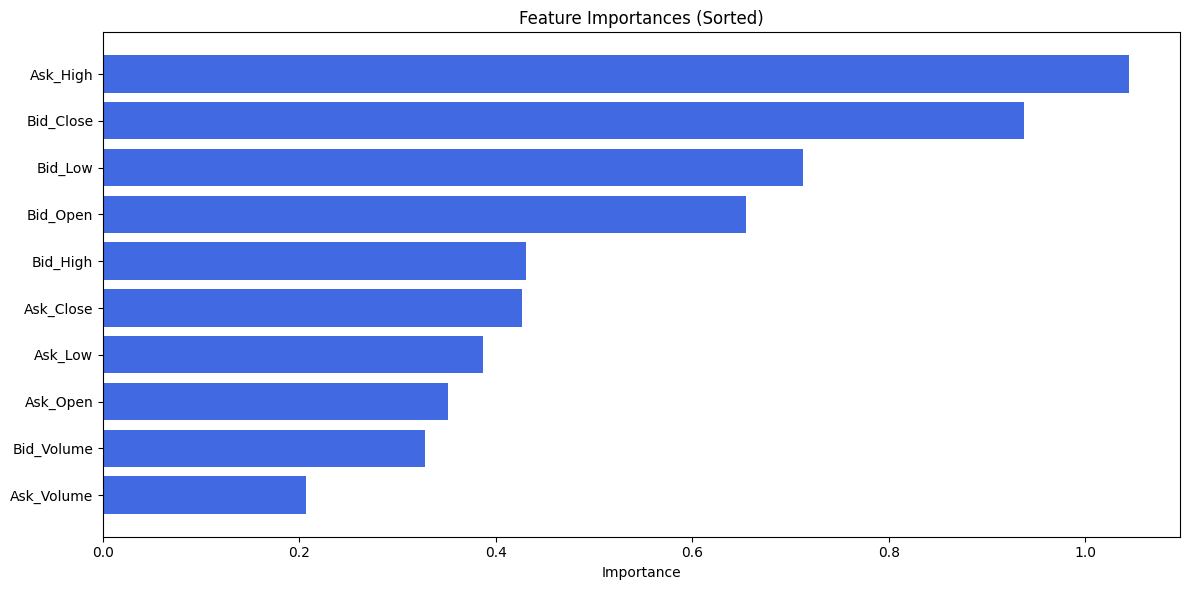

In [65]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

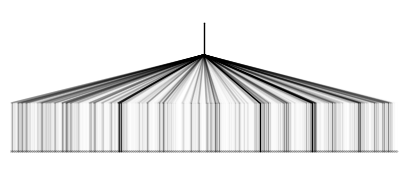

In [66]:
model.final_kan.plot()

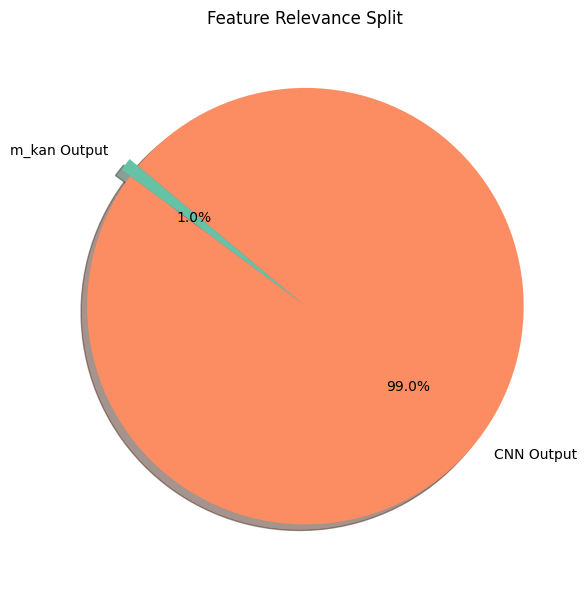

In [67]:
feature_score = model.final_kan.feature_score
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=4)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

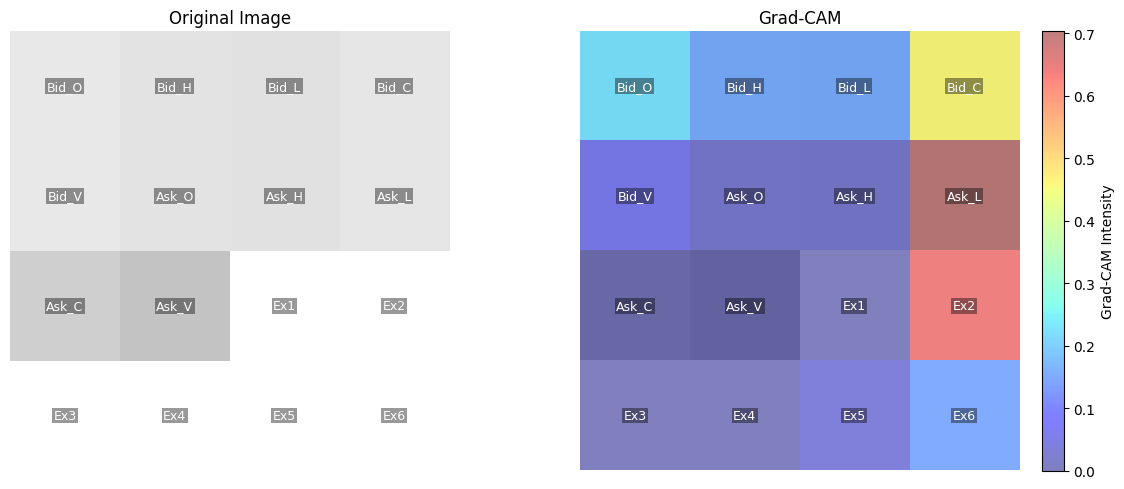

In [68]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

Computing Grad-CAM: 100%|██████████| 367/367 [00:35<00:00, 10.24it/s]


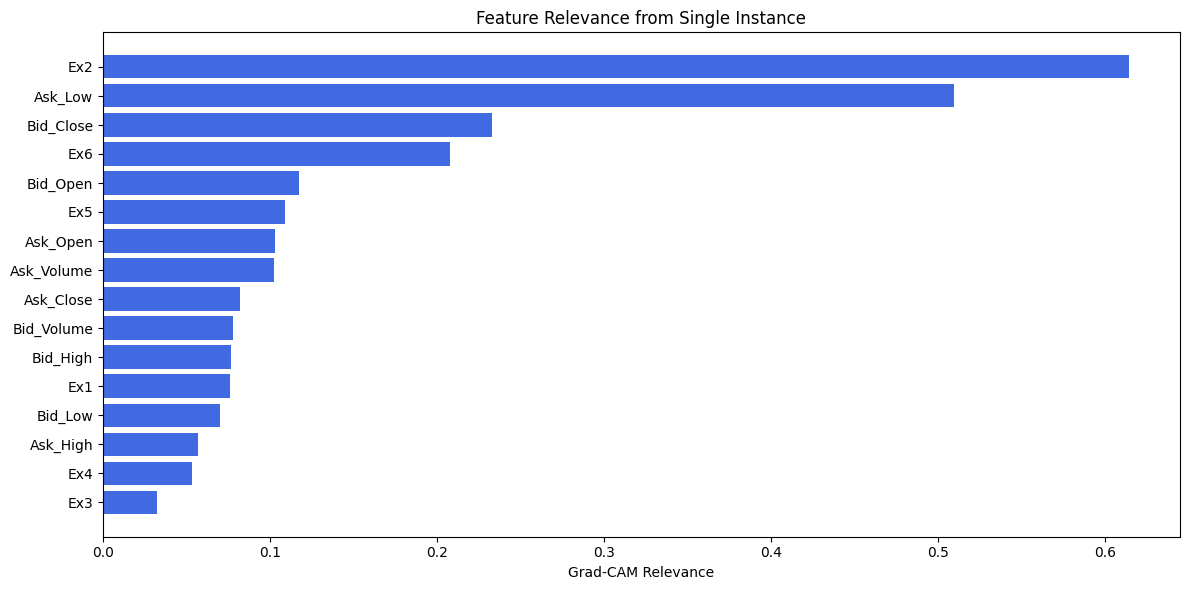

In [69]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)
plot_feature_relevance_bar(avg_scores)

# Hybrid Model4 training ✅ Top 2 Configurations

### 1. width=[10, 2, 1], grid=4, lamb=0.0001| best_epoch=18 | avg_acc=0.73569

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.03e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:02<00:00,  1.03s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 4 epoch
tensor(0.6431, device='cuda:0')


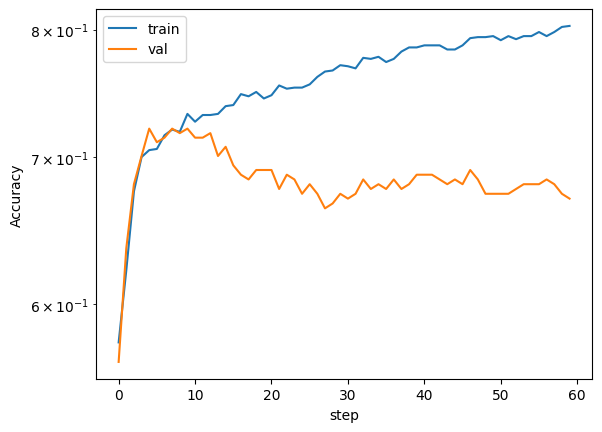

In [70]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=2, kan_grid=4)  # Attempt to create Model3
model_state, results, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=60, lamb=0.0001,
                                                   metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])

plot_training_ACC(model, model_state, dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                  results['train_acc_hybrid'], results['val_acc_hybrid'])

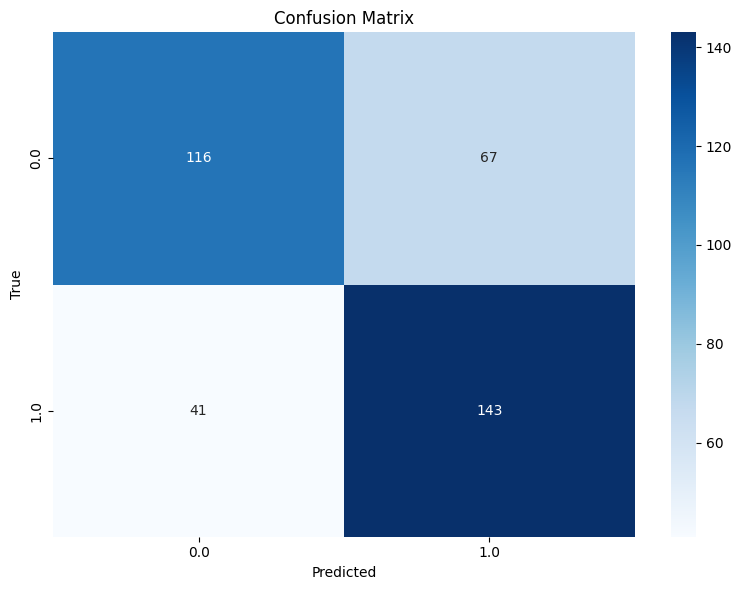

In [71]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

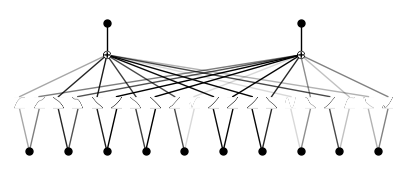

In [72]:
model.m_kan.plot()

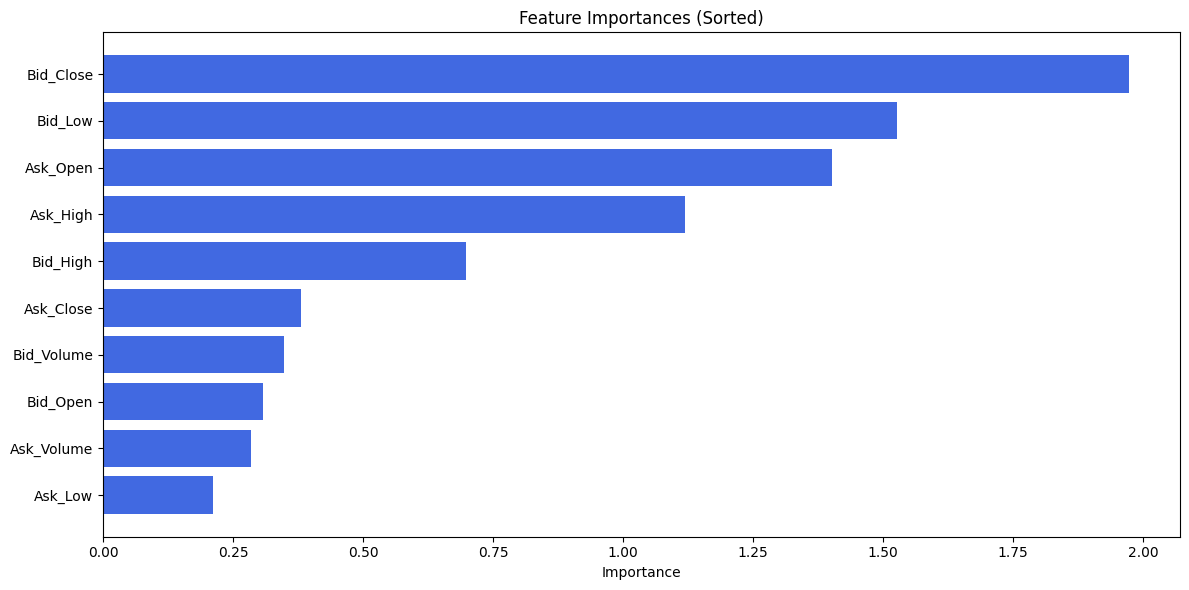

In [73]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

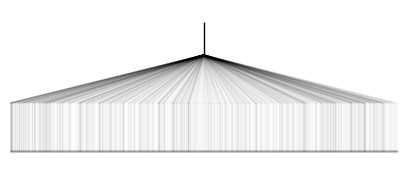

In [74]:
model.final_kan.plot()

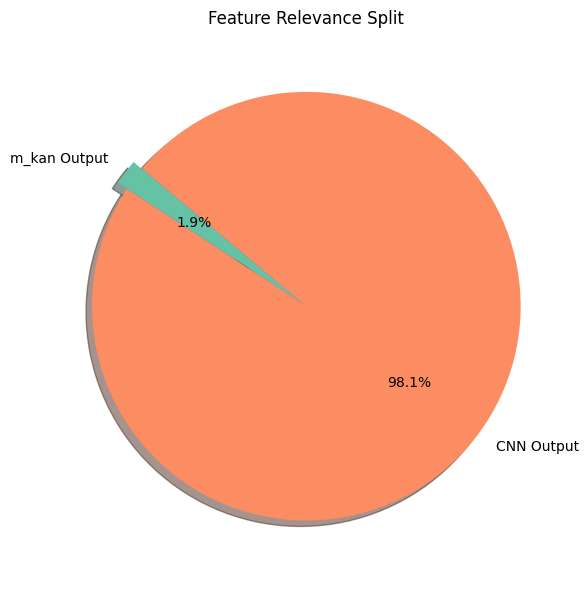

In [75]:
feature_score = model.final_kan.feature_score
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=2)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

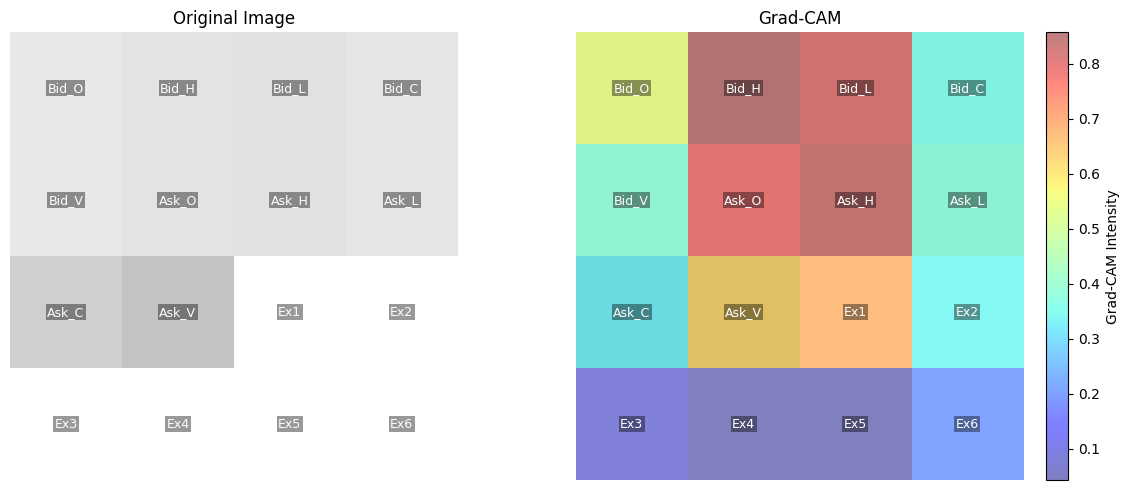

In [76]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

Computing Grad-CAM: 100%|██████████| 367/367 [00:30<00:00, 12.04it/s]


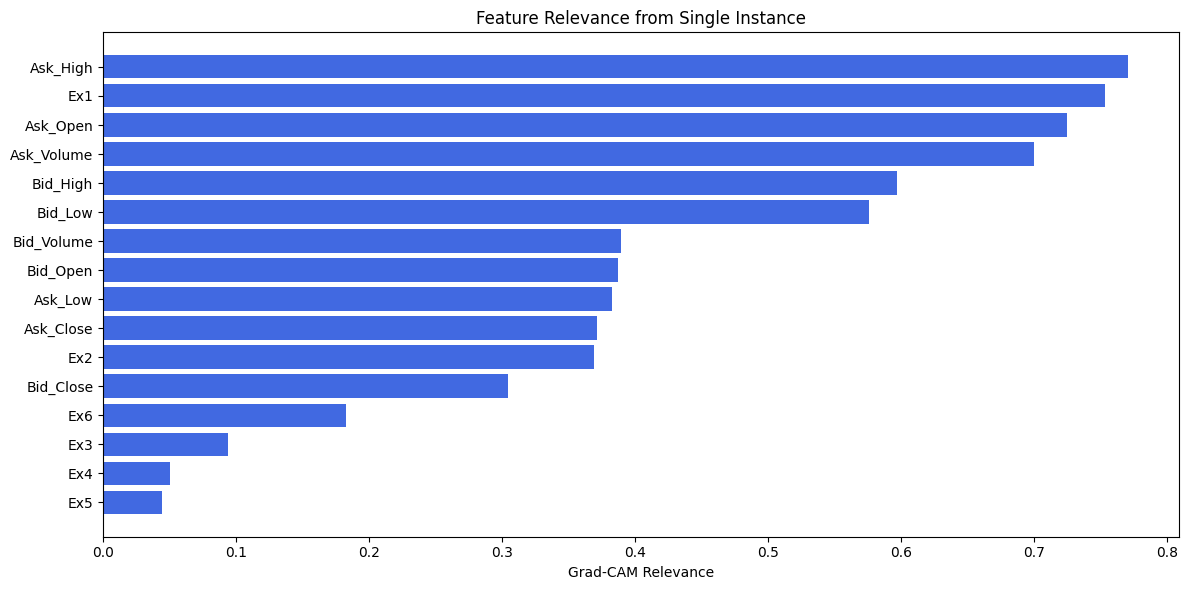

In [77]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)
plot_feature_relevance_bar(avg_scores)

### 2. width=[10, 5, 1], grid=6, lamb=0.0001| best_epoch=10 | avg_acc=0.73569

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.85e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:13<00:00,  1.23s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 19 epoch
tensor(0.6894, device='cuda:0')


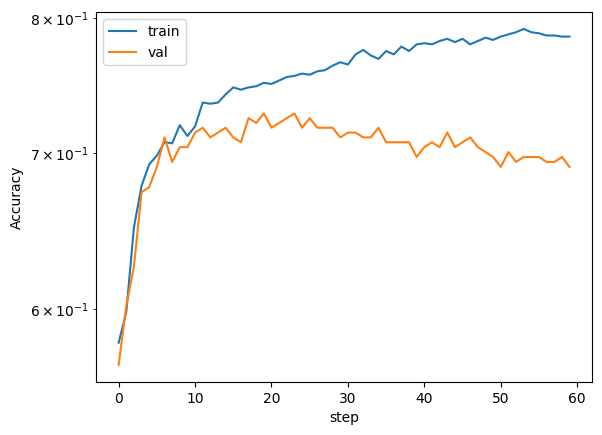

In [78]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=5, kan_grid=6)  # Attempt to create Model3
model_state, results, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=60, lamb=0.0001,
                                                   metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])

plot_training_ACC(model, model_state, dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                  results['train_acc_hybrid'], results['val_acc_hybrid'])

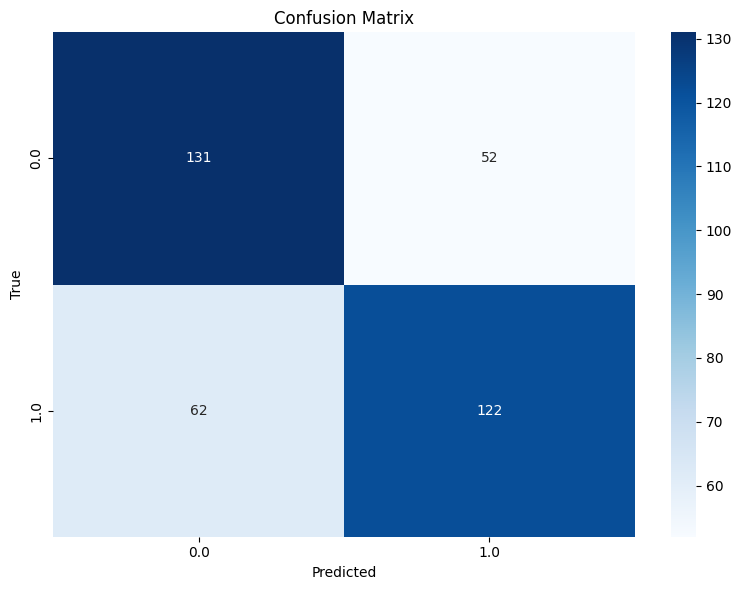

In [79]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

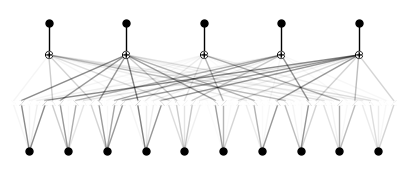

In [80]:
model.m_kan.plot()

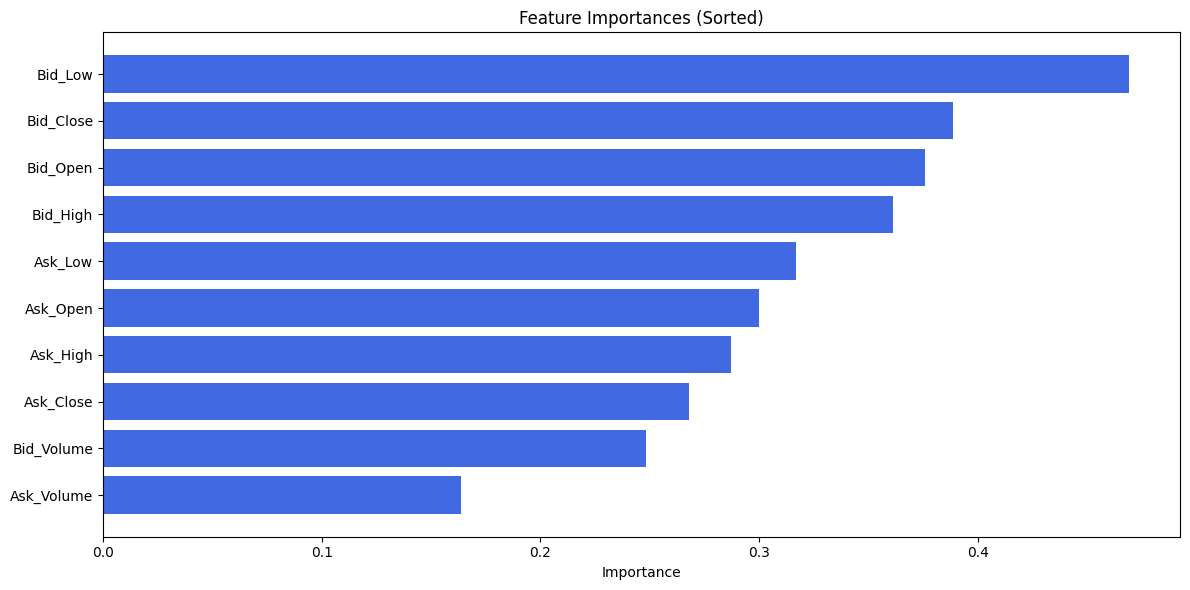

In [81]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

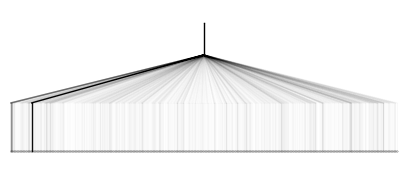

In [82]:
model.final_kan.plot()

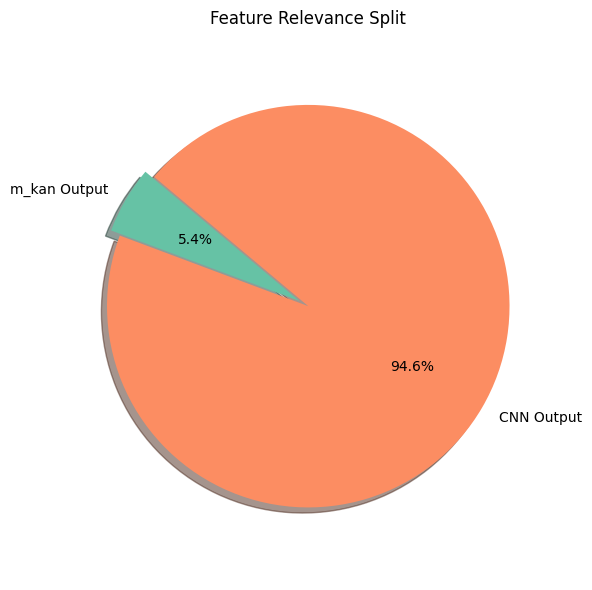

In [83]:
feature_score = model.final_kan.feature_score
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=5)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

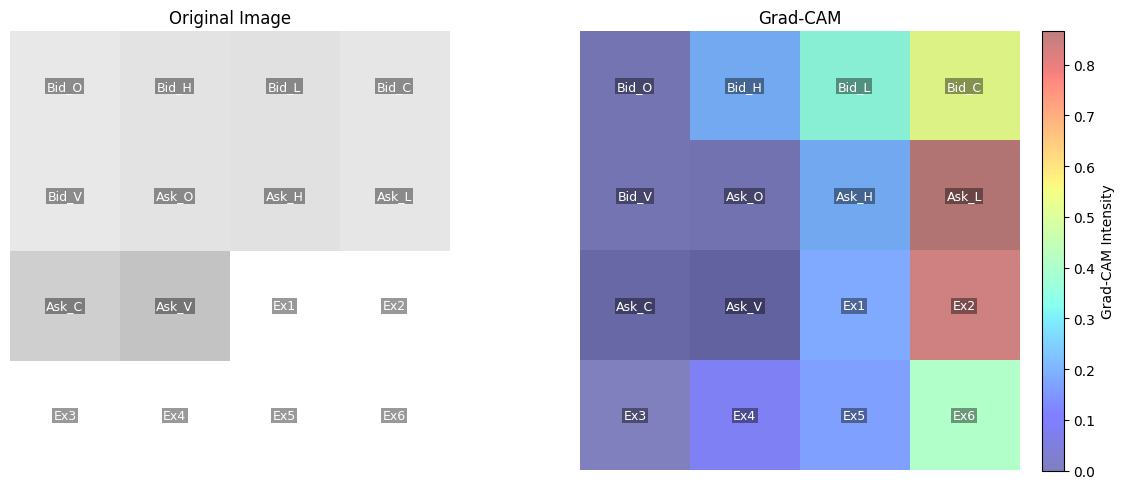

In [84]:
i = 4 # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=1
)

Computing Grad-CAM: 100%|██████████| 367/367 [00:37<00:00,  9.82it/s]


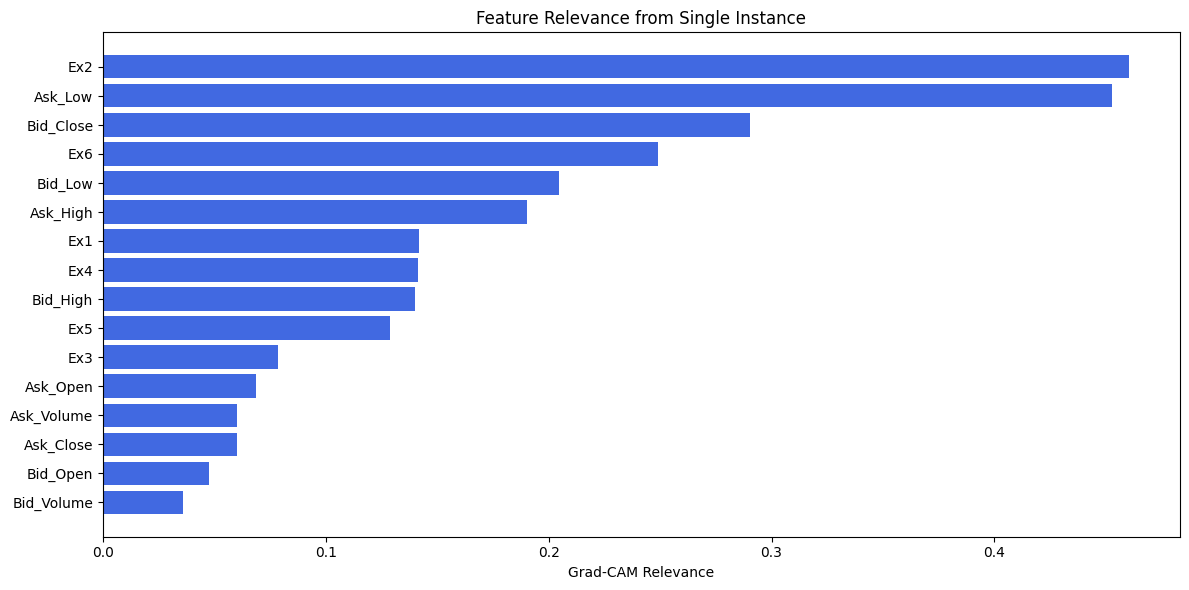

In [85]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=1
)
plot_feature_relevance_bar(avg_scores)

# Bonus Hybrid

In [86]:
class Model5(nn.Module):
    def __init__(self, imgs_shape, kan_grid=kan_grid, device=device):
        super(Model5, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2, padding=1),
            nn.LayerNorm([16, 9, 9]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            #nn.MaxPool2d(2),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, cnn_input):
        cnn_input = cnn_input.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        
        #concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(cnn_output)

NameError: name 'kan_grid' is not defined

In [ ]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        #old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_img"].shape[0]
    n_eval  = dataset["val_img"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            #mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            # model.final_kan.update_grid(mlp_batch)
            cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            # concatenated  = model.get_concat_output(cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(cnn_output)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                #mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                    if reg_metric == 'edge_backward':
                        #model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        #model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    # if sum_f_reg:
                    #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from val_loader)
        #mlp_eval = dataset["val_input"][eval_indices]
        img_eval = dataset["val_img"][eval_indices]
        target_eval = dataset["val_label"][eval_indices]
        eval_loss = loss_fn(model(img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return results, best_model_state

In [ ]:
import traceback

def try_create_model2(model_class, attributes, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [ ]:
model5 = try_create_model2(Model5, attributes, imgs_shape)  # Attempt to create Model4
metrics5, best_model_state = fit_hybrid_dataloaders2(model5, dataset, opt="LBFGS", steps=30, lamb=.00000001)
model5.load_state_dict(best_model_state)
print(average_rmse(model5(dataset['test_img']), dataset['test_label']))
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')